# Sampling algorithm (VE) 테스트.

1. Cartesian에서 sampling을 하는경우와 distance space에서 샘플링을 하는 경우를 다룸.
2. Time-reversal 샘플링 과정에서 $h$ 를 없애고 샘플링을 하는것을 고려중

- Reference: *Zhou, L., Lou, A., Khanna, S., & Ermon, S. (2023). Denoising Diffusion Bridge Models. arXiv preprint arXiv:2309.16948.*

---
Time reversal sampling은 $x_{t} = x_{t+1} - dx_{t}$ 꼴으로 진행된다.

$$dx_{t}=\left[f(x_t, t) - g^2(t)\left(s(x_t, t, x_0, x_T)-h(x_t , t, x_T) \right)\right]dt + g(t)dw_t$$

여기서 

- $$ s^* = \nabla_{x_t} q(x_t \vert x_0, x_T) = 2 (\mu_t - x_t) / \hat{\sigma}^2_t $$
$$ s(x_t, t, x_0, T) = \nabla_{x_t} log q(x_t \vert x_0, x_T) = (\mu_t - x_t) / \hat{\sigma}^2_t  $$

where, 
$$\mu_t = \frac{\sigma_t^2}{\sigma_T^2} x_T + (1-\frac{\sigma_t^2}{\sigma_T^2}) x_0$$

$$\hat{\sigma}^2_t := \sigma^2_t\left(1-\frac{\sigma_t^2}{\sigma_T^2}\right)$$



In practice,

$$d\sigma^2(t) /dt = \beta(t) = g^2(t)$$

$$\{\beta_{t}\}=\{\beta_0, \beta_1, \beta_2, ..., \beta_{T-1}\}$$

$$\sigma^2_t = \int^t_0 \beta(t) dt = \sum_{i=0}^{t-1}\beta_{i} + \sigma^2_0\quad \forall 1\le t \le T$$

그리고, 실질적으로 discrete하게 SDE를 푸는 과정에서 $h, f = 0$ 이라고 가정하고, wiener process없이 문제를 푼다면 

- $$dx_t= -2 \frac{\beta_t}{\sigma^2_t(1-\sigma^2_t/\sigma^2_T)}(\mu_t - x_t)$$
$$dx_t= - \frac{\beta_t}{\sigma^2_t(1-\sigma^2_t/\sigma^2_T)}(\mu_t - x_t)$$




---
문제점 : 

1. $t \to 0$ 경우 score값이 불안정해지면서, 에러가 약간 더 커지는 상황 발생
2. $t \to T$ 경우 score값이 **매우** 불안정해지면서, 구조가 완전히 망가져버리는 현상 발생

In [1]:
import numpy as np
import torch

from scipy.spatial.distance import cdist, pdist
import scipy

import os
import ase.io
import ase
import sys

from torch_scatter import scatter_add

from lst_interp import *

import matplotlib.pyplot as plt
# import seaborn as sns

torch.set_num_threads(4)

## fix random seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    return
set_seed(0)

/home/jhwoo/.conda/envs/pysis-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Sampling Parameters study

1. $\beta_t$의 함수꼴을 sigmoid style을 사용했을 때, $t\to T$ 에서 score가 **매우** 불안정해지는 것을 확인
    - bell shaped curve를 사용하면, 여전히 튀는 현상이 발생하기는 하지만 에러 스케일이 0.01 수준으로 매우 양호해진다.
    - $t\to T$에서 $\beta$를 0 으로 수렴시켜서 update양을 조절하는게 주요하지 않았을까 생각한다.
2. $\sigma_0 = 0$ 이 되면 numerically 문제가 생긴다.
    - 왜냐하면 $(\hat{\sigma}_t)^{-1} \to \infty$ as $t\to 0$.
    - $\sigma_0 \gt 0$ 이면 $\beta_t \to 0$ 으로 만들고, $(\hat{\sigma}_t)^{-1} \lt \infty$ 로 만들 수 있어서 문제를 해결할 수 있다.

---

### $\beta(t)$ is truncated normal distribution, defined on [0, 1]
### $\sigma^2(t)=\int_0^{t}\beta(s)ds + \sigma^2(0)$ 
### $\sigma^2(0)/\int_0^{1}\beta(s)ds = 0.005$


In [ ]:
class SamplingParams:

    def __init__(self, beta_std, sigma_max, sigma_min=None, sigma1_correction=1e-4):
        self.c = 1.0
        # self.c = np.sqrt(0.1)
        self.sigma_linear_coef = 0.0
        self.normalizer = 1 / (beta_std * np.sqrt(2 * np.pi))
        self.beta_std = beta_std
        self.sigma_max = sigma_max
        if sigma_min is None:
            sigma_min = sigma_max * 5e-3

        self.sigma_min = sigma_min
        self.sigma_1 = self.sigma_square(1.0) + sigma1_correction
        self.sigma_0 = self.sigma_square(0.0)
        # print(self.sigma_1, self.sigma_0)
        print("sigma_1, sigma_0 = ", self.sigma_1, self.sigma_0)
        return

#     def beta(self, t):
#         return self.c**2 * torch.ones_like(t)

#     def sigma_square(self, t):
#         return self.c**2 * t + 1e-3
    
    def beta(self, t):
        return self.c * 2 * t
        
    def sigma_square(self, t):
        return self.c * t**2 + 1e-5
        
#     def beta(self, t):
#         if isinstance(t, torch.Tensor):
#             b = torch.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
#         else:
#             b = np.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
#         b = b * self.normalizer * self.sigma_max
#         b += self.sigma_linear_coef
#         return b

#     def sigma_square(self, t):
#         erf_scaler = self.sigma_max / 2 # / (self.beta_std * np.sqrt(8) * 2)
#         if isinstance(t, torch.Tensor):
#             s_sq = erf_scaler * (1 + torch.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
#             s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
#             s_sq += self.sigma_linear_coef * t
#             return s_sq

#         else:
#             s_sq = erf_scaler * (1 + scipy.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
#             s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
#             s_sq += self.sigma_linear_coef * t
#             return s_sq
        
    def SNR(self, t):
        return self.sigma_square(t) / self.sigma_1

In [3]:
# debugging

class Wrapper_test:
    def __init__(self, atoms_0, atoms_T, q_type="DM"):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        assert q_type in ["DM", "morse"]
        self.q_type = q_type

        self.re = torch.Tensor(self.get_re(atoms_T))
        self.alpha, self.beta = 1.7, 0.01
        self.morse_scaler = morse_scaler(self.re, self.alpha, self.beta)
        self.scaler_factor = 1.0; print(f"Debug: self.scaler_factor set to {self.scaler_factor}")
        return

    def get_re(self, atoms, threshold=np.inf):
        from scipy.spatial import KDTree

        rijset = set()
        tree = KDTree(atoms.positions)
        pairs = tree.query_pairs(threshold)
        rijset.update(pairs)
        rijlist = sorted(rijset)

        radius = np.array([ATOMIC_RADIUS.get(atom.capitalize(), 1.5) for atom in atoms.get_chemical_symbols()])
        re = np.array([radius[i] + radius[j] for i, j in rijlist])
        return re

    def eq_transform(self, score_d, pos, edge_index, edge_length):
        if self.q_type == "morse":
            edge_length = torch.Tensor(pdist(pos))
            
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re)
            # dd_dr += self.beta * self.re / (edge_length ** 3)
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr = dd_dr.reshape(-1, 1)
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]]) * 0.5
            score_d = score_d.reshape(-1, 1)
            score_d *= self.scaler_factor
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        elif self.q_type == "DM":
            N = pos.size(0)
            dd_dr = (1.0 / edge_length).reshape(-1, 1) * (pos[edge_index[0]] - pos[edge_index[1]]) * 0.5
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        else:
            raise NotImplementedError
        return score_pos

    def pos_to_dist(self, pos):
        if self.q_type == "morse":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif self.q_type == "DM":
            length = torch.Tensor(pdist(pos))
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        else:
            raise NotImplementedError
        return index, length



# atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
# # # atoms_T = list(ase.io.iread("pm7/pm7_rxn_r.xyz"))
# atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))
# # # atoms_T = list(ase.io.iread("wb97xd3_geodesic/wb97xd3_geodesic_rxn_ts.xyz"))
# # q_type = "morse"

idx = 0
# find matched index
xT = atoms_T[idx]
file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
gt_idx = int(file_name[2:])
x0 = atoms_0[gt_idx]


wrapper = Wrapper(x0, xT, q_type)
res1 = wrapper.pos_to_dist(wrapper.atoms_0.positions)

ts_tilde_q = wrapper.pos_to_dist(wrapper.atoms_0.positions)[1]
ts_q = wrapper.pos_to_dist(wrapper.atoms_T.positions)[1]
# print(ts_tilde_q)
# print(ts_q)
print(wrapper.pos_to_dist(wrapper.atoms_0.positions)[0])

print(ts_tilde_q - ts_q)
print("--------")

ts_tilde_q = wrapper.pos_to_dist(wrapper.atoms_0.positions)[1]
ts_q = wrapper.pos_to_dist(wrapper.atoms_T.positions + np.random.randn(*wrapper.atoms_T.positions.shape) * 0.1)[1]
print(ts_tilde_q - ts_q)
print("--------")


wrapper = Wrapper(x0, xT, "DM")
res2 = wrapper.pos_to_dist(wrapper.atoms_0.positions)

ts_tilde_q = wrapper.pos_to_dist(wrapper.atoms_0.positions)[1]
ts_q = wrapper.pos_to_dist(wrapper.atoms_T.positions)[1]
# print(ts_tilde_q)
# print(ts_q)
print(ts_tilde_q - ts_q)
print("--------")

print(res1[1])
print(res2[1])

NameError: name 'atoms_T' is not defined

In [73]:
## wrapper class to save atoms object
import sys
sys.path.append("/home/share/DATA/NeuralOpt/Interpolations/Geodesic_interp")
# from get_geodesic_energy import get_rijlist_and_re, compute_wij, morse_scaler
from get_geodesic_energy import morse_scaler, ATOMIC_RADIUS


class Wrapper:
    def __init__(self, atoms_0, atoms_T, q_type="DM", alpha=1.7, beta=0.01, gamma=0.01):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        # assert q_type in ["DM", "morse"]
        self.q_type = q_type

        self.re = torch.Tensor(self.get_re(atoms_T))
        # self.re = torch.Tensor(self.get_re(atoms_T))
        self.alpha, self.beta = alpha, beta
        self.gamma = gamma
        self.morse_scaler = morse_scaler(self.re, self.alpha, self.beta)
        self.scaler_factor = 1.0; print(f"Debug: self.scaler_factor set to {self.scaler_factor}")
        return


    def get_re(self, atoms, threshold=np.inf):
        from scipy.spatial import KDTree

        rijset = set()
        tree = KDTree(atoms.positions)
        pairs = tree.query_pairs(threshold)
        rijset.update(pairs)
        rijlist = sorted(rijset)

        radius = np.array([ATOMIC_RADIUS.get(atom.capitalize(), 1.5) for atom in atoms.get_chemical_symbols()])
        re = np.array([radius[i] + radius[j] for i, j in rijlist])
        return re

    def eq_transform(self, score_d, pos, edge_index, edge_length):
        if self.q_type == "morse":
            edge_length = torch.Tensor(pdist(pos))
            
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr = dd_dr.reshape(-1, 1)
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]]) * 0.5
            score_d = score_d.reshape(-1, 1)
            score_d *= self.scaler_factor
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        elif self.q_type == "DM":
            N = pos.size(0)
            dd_dr = (1.0 / edge_length).reshape(-1, 1) * (pos[edge_index[0]] - pos[edge_index[1]]) * 0.5
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        elif self.q_type == "morse+DM":
            edge_length = torch.Tensor(pdist(pos))
            
            N = pos.size(0)
            # dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            # dd_dr += self.beta * self.re / (edge_length ** 3)
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr += self.gamma / edge_length
            dd_dr = dd_dr.reshape(-1, 1)
            score_d *= self.scaler_factor
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]]) * 0.5
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        else:
            raise NotImplementedError
        return score_pos

    def pos_to_dist(self, pos):
        if self.q_type == "morse":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif self.q_type == "DM":
            length = torch.Tensor(pdist(pos))
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif self.q_type == "morse+DM":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            wij += self.gamma * rij
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        else:
            raise NotImplementedError
        return index, length

    def pinned_score(self, x_t, t, params, x_T):
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        # calc score
        diff = x_T - x_t
        coeff = beta_t * 2 / (sigma_T_square - sigma_t_square)
        score = diff * coeff
        return score

    def pinned_score2(self, x_t, t, params, x_T):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        # calc diff
        index, d_t = self.pos_to_dist(x_t)
        index, d_T = self.pos_to_dist(x_T)
        diff = d_T - d_t
        diff_pos = self.eq_transform(diff, x_t, index, d_t)

        # calc score
        coeff = beta_t * 2 / (sigma_T_square - sigma_t_square)
        score = diff_pos * coeff
        return score

    def pinned_diffusion_proccess(self, x_t, t, betas, x_T, coord="Cartesian"):
        beta_t = betas[t]
        if coord == "Cartesian":
            dx = beta_t * self.pinned_score(x_t, t, betas, x_T) + torch.sqrt(beta_t) * torch.randn_like(x_t)
        else:
            dx = beta_t * self.pinned_score2(x_t, t, betas, x_T) + torch.sqrt(beta_t) * torch.randn_like(x_t)
        x_tp1 = x_t + dx
        return x_tp1

    def reverse_diffusion_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            reverse_score_, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (h_coeff * self.pinned_score(x_t, t, params, x_T) - 1.0 * reverse_score_) * dt 
        else:
            reverse_score_, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (h_coeff * self.pinned_score2(x_t, t, params, x_T) - 1.0 * reverse_score_) * dt

        index, d_t = self.pos_to_dist(x_t)
        dw_d = torch.sqrt(beta_t * dt) * torch.randn_like(d_t)
        # dw_d *= 5 # debugging: upscaling noise
        dw_pos = self.eq_transform(dw_d, x_t, index, d_t)
        # dw = torch.sqrt(beta_t * dt) * torch.randn_like(x_t)
        dx += dw_pos
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_ode_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            reverse_score_, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (h_coeff * self.pinned_score(x_t, t, params, x_T) - 0.5 * reverse_score_) * dt
        else:
            reverse_score_, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (h_coeff * self.pinned_score2(x_t, t, params, x_T) - 0.5 * reverse_score_) * dt
            # print(f"Debug: t={t}, dx=\n{dx}")
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_score(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)

        # calc difference
        diff = mu_hat - x_t

        # calc_score    
        coeff =  2 / (sigma_t_hat_square) * beta_t
        score = diff * coeff

        # for debug
        if self.q_type == "DM":
        # if self.q_type in ["DM", "morse"]: # debugging # calculate err corresponding the metric
            _, d_T = self.pos_to_dist(x_T)
            _, d_t = self.pos_to_dist(x_t)
            _, d_0 = self.pos_to_dist(x_0)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
            v1 = (d_mu_hat - d_t).abs().mean()
            # v2 = (d_mu_hat - d_T).abs().mean()
            v2 = (d_0 - d_t).abs().mean()
            v3 = (mu_hat - x_t.numpy()).abs().mean()
            v4 = (mu_hat - x_T.numpy()).abs().mean()
        # elif self.q_type == "morse":
        elif self.q_type in ["morse", "morse+DM"]:
            version = "DMAE"
            # version = "Morse-RMSD"
            if version == "DMAE":
                d_T = torch.Tensor(pdist(x_T))
                d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
                d_t = torch.Tensor(pdist(x_t))
                d_0 = torch.Tensor(pdist(x_0))
                v1 = (d_mu_hat - d_t).abs().mean()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).abs().mean()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
            else:
                _, d_T = self.pos_to_dist(x_T)
                _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
                _, d_t = self.pos_to_dist(x_t)
                _, d_0 = self.pos_to_dist(x_0)
                v1 = (d_mu_hat - d_t).norm()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).norm()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
        else:
            raise NotImplementedError
        if verbose:
            print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
        return score, v1, v2, v3, v4

    def reverse_score2(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        typo = 2
        # typo = 3; print("Debug: using LST", end="")
        if typo == 1:
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        if typo == 2:
            _, d_0 = self.pos_to_dist(x_0)
            _, d_T = self.pos_to_dist(x_T)
            d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)  # for debugging
        if typo == 3:
            mu_hat = interpolate_LST(x_0.numpy(), x_T.numpy(), SNRTt.item())
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        
        # calc difference
        index, d_t = self.pos_to_dist(x_t)
        diff_d = d_mu_hat - d_t
        diff_pos = self.eq_transform(diff_d, x_t, index, d_t)

        # calc score
        coeff =  2 / (sigma_t_hat_square) * beta_t
        score = diff_pos * coeff

    
        # for debugging
        # version = "DMAE"
        # version = "Morse-RMSD"
        d_T = torch.Tensor(pdist(x_T))
        d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
        d_t = torch.Tensor(pdist(x_t))
        d_0 = torch.Tensor(pdist(x_0))
        v1 = (d_mu_hat - d_t).abs().mean()  # DMAE
        v2 = (d_0 - d_t).abs().mean()  # DMAE

        import copy
        original_q_type = copy.deepcopy(self.q_type)
        self.q_type = "morse"
        _, d_T = self.pos_to_dist(x_T)
        _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
        _, d_t = self.pos_to_dist(x_t)
        _, d_0 = self.pos_to_dist(x_0)
        v3 = (d_mu_hat - d_t).norm()  # q-norm
        v4 = (d_0 - d_t).norm()  # q-norm
        self.q_type = original_q_type
        

        if verbose:
            print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
        return score, v1, v2, v3, v4

    def my_sampling_process(self, x_t, t, dt, coeff, x_0, x_T, coord="Cartesian"):
        if coord == "Cartesian":
            raise NotImplementedError
        else:
            _, d_0 = self.pos_to_dist(x_0)
            _, d_T = self.pos_to_dist(x_T)
            # d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
            d_mu_hat = d_0
            
            # calc difference
            index, d_t = self.pos_to_dist(x_t)
            diff_d = d_mu_hat - d_t
            diff_pos = self.eq_transform(diff_d, x_t, index, d_t)  # diff_d -> diff_pos 가면서, 스케일이 팍 죽어버려쓰.
            score = diff_pos * coeff
            dx = - score * dt
            x_tm1 = x_t - dx
            if t < 0.01:
                print(f"Debug: t={t}, diff_d.norm()={diff_d.norm()}")
                print(f"Debug: t={t}, diff_pos.norm()={diff_pos.norm()}")
                print(f"Debug: t={t}, score.norm()={score.norm()}")
                print(f"Debug: t={t}, dx.norm()={dx.norm()}")
            
            ## calculate error
            # version = "DMAE"
            # version = "Morse-RMSD"
            # if version == "DMAE":
            d_t = torch.Tensor(pdist(x_tm1))
            d_0 = torch.Tensor(pdist(x_0))
            v1 = (d_0 - d_t).abs().mean()  # DMAE
            # else:
            _, d_t = self.pos_to_dist(x_tm1)
            _, d_0 = self.pos_to_dist(x_0)  # q norm
            v2 = (d_0 - d_t).norm()
            return x_tm1, v1, v2

std_beta, sigma_max, sigma_min =  0.125 0.1 1e-10
sigma_1, sigma_0 =  1.0000010001 1e-06


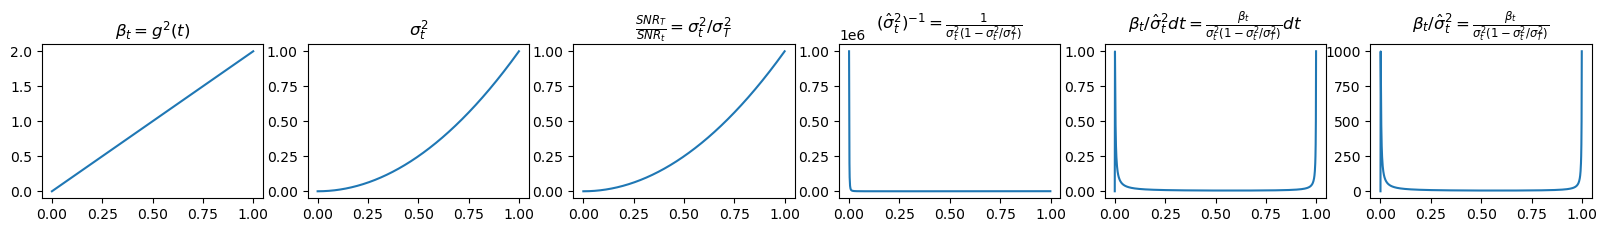

In [76]:
std_beta = 0.125
# std_beta = 0.1
# std_beta = 0.07
# std_beta = 0.05

sigma_max = 0.1
# sigma_max = 0.05
# sigma_max = 0.01
sigma_min = sigma_max * 1e-4
sigma1_correction = 1e-7


sigma_min = 0.0
sigma1_correction = 0.0
sigma_min = 1e-7
sigma1_correction = 1e-7
sigma_min = 1e-5
sigma1_correction = 1e-5
sigma_min = 1e-10
sigma1_correction = 1e-10

# print(std_beta, sigma_max, sigma_min)
print("std_beta, sigma_max, sigma_min = ", std_beta, sigma_max, sigma_min)
params = SamplingParams(std_beta, sigma_max, sigma_min=sigma_min, sigma1_correction=sigma1_correction)

num_time_steps = 1000
t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
betas = params.beta(t)
sigma_square = params.sigma_square(t)
SNRTt = params.SNR(t)

fig, axs = plt.subplots(1, 6, figsize=(20, 2))
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 10})  # Set the global font size to 12

axs = axs.flatten()

# for ax in axs:
#     ax.set_xlim(0, 4)
    
ax = axs[0]
ax.plot(t, betas)
ax.set_title(r"$\beta_t = g^2(t)$")

ax = axs[1]
ax.plot(t, sigma_square)
ax.set_title("$\sigma_{t}^{2}$")

ax = axs[2]
ax.plot(t, SNRTt)
ax.set_title(r"$\frac{SNR_{T}}{SNR_{t}}=\sigma_t^2/\sigma_T^2$")

ax = axs[3]
ax.set_title(r"$(\hat{\sigma}_t^2)^{-1}=\frac{1}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$")
ax.plot(t, (1 / sigma_square / (1 - SNRTt)))

ax = axs[4]
ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2 dt=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)} dt$")
dt = 1 / len(betas)
ax.plot(t, (betas / sigma_square / (1 - SNRTt)) * dt)

ax = axs[5]
ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$")
dt = 1 / len(betas)
ax.plot(t, (betas / sigma_square / (1 - SNRTt)))

In [52]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz")); print("load wb97xd3/wb97xd3_rxn_ts.xyz as atoms_0")
# atoms_T = list(ase.io.iread("wb97xd3/wb97xd3_rxn_r.xyz"))
# atoms_T = list(ase.io.iread("pm7/pm7_rxn_r.xyz")); print("load pm7/pm7_rxn_r.xyz as atoms_T")
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz")); print("load pm7/pm7_rxn_ts.xyz as atoms_T")
# atoms_T = list(ase.io.iread("wb97xd3_geodesic/wb97xd3_geodesic_rxn_ts.xyz"))

def experiment1(idx, sampling_type, coord_type, h_coeff, num_time_steps=200, verbose=False, plot=True, q_type="morse"):
    set_seed(0)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]


    # gamma = 0.8
    gamma = 0.0
    alpha, beta = 1.7, 0.01
    alpha *= (1 - gamma)
    beta *= (1 - gamma)
    # wrapper = Wrapper(x0, xT, q_type=q_type)
    # wrapper = Wrapper(x0, xT, q_type=q_type, alpha=0.5, beta=0.01)
    # wrapper = Wrapper(x0, xT, q_type=q_type, alpha=0.1, beta=0.0)
    # alpha, beta = 1.5, 0.2
    print(f"Debug: alpha, beta = {alpha}, {beta}")
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma)
    # wrapper.scaler_factor = 1.; print(f"Debug: self.scaler_factor set to {wrapper.scaler_factor}")
    # wrapper.scaler_factor = 2.; print(f"Debug: self.scaler_factor set to {wrapper.scaler_factor}")

    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())
    # posT = pos0 + torch.randn_like(pos0) * 0.05; print(f"Debug: random noised pos0 is used as posT.")
    # posT += torch.randn_like(posT) * 0.1; print(f"Debug: random noised is added to posT for breaking plane.")

    t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s = []
    v2s = []
    v3s = []
    v4s = []

    if verbose:
        print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
    for idx, i in enumerate(torch.flip(t, dims=(0,))):
        if sampling_type == "hybrid":
            if idx % 2 == 0:
                x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
            else:
                x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        elif sampling_type == "ode":
            x, v1, v2, v3, v4 = wrapper.reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        else:
            # sde
            x, v1, v2, v3, v4 = wrapper.reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)

        v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
        reverse_traj.append(x)
    for j in range(0):
        for idx, i in enumerate(torch.flip(t, dims=(0,))):
            if idx < 200:
                continue
            if sampling_type == "hybrid":
                if idx % 2 == 0:
                    x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
                else:
                    x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
            elif sampling_type == "ode":
                x, v1, v2, v3, v4 = wrapper.reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
            else:
                # sde
                x, v1, v2, v3, v4 = wrapper.reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)

            v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
            reverse_traj.append(x)


    if plot:
        label = f"{coord_type}, {sampling_type}"
        # plt.plot(v2s[::-1])
        # plt.plot(v4s[::-1])
        # plt.plot(v1s[::-1], label=label)
        plt.plot(v2s[::-1], label=label)
        # plt.plot(v3s[::-1])
        plt.xlabel(r"time step", fontsize=16)
        if q_type == "morse":
            plt.ylabel(r"||$\hat{q}_t - q_t$||", fontsize=16)
        # elif q_type == "DM":
        elif q_type in ["morse", "morse+DM"]:
            plt.ylabel(r"||$\hat{d}_t - d_t$||", fontsize=16)
#         else:
#             raise NotImplementedError

    # return v1s[::-1]
    return v2s[::-1]

load wb97xd3/wb97xd3_rxn_ts.xyz as atoms_0
load pm7/pm7_rxn_ts.xyz as atoms_T


q_type = morse
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


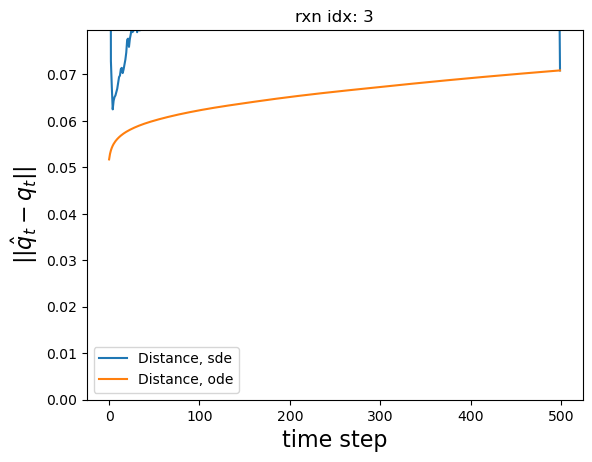

err_at_zero_t =  [3.1805131435394287, 0.0517188236117363]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


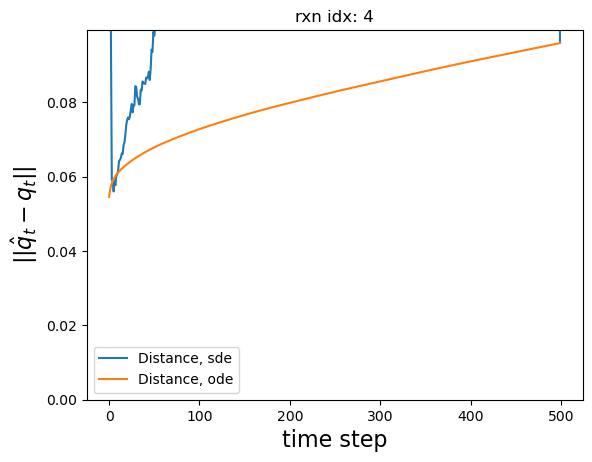

err_at_zero_t =  [11.127728462219238, 0.054540202021598816]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


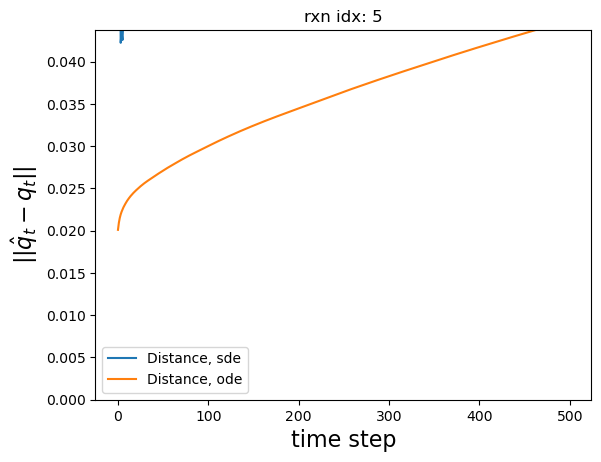

err_at_zero_t =  [2.340374231338501, 0.020097238942980766]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


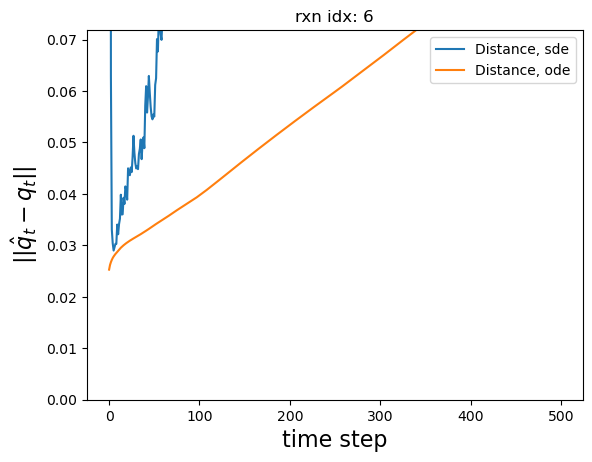

err_at_zero_t =  [0.979645848274231, 0.02528383396565914]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


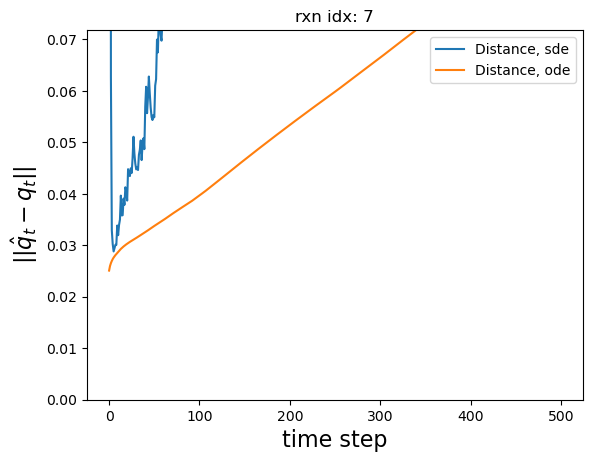

err_at_zero_t =  [0.9790003299713135, 0.02508835308253765]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


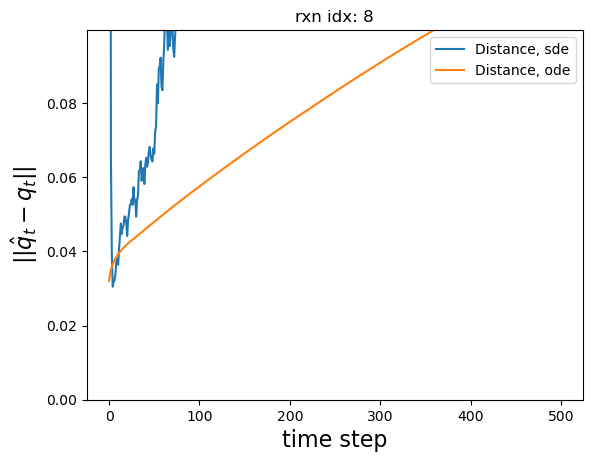

err_at_zero_t =  [1.228416919708252, 0.03209243342280388]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


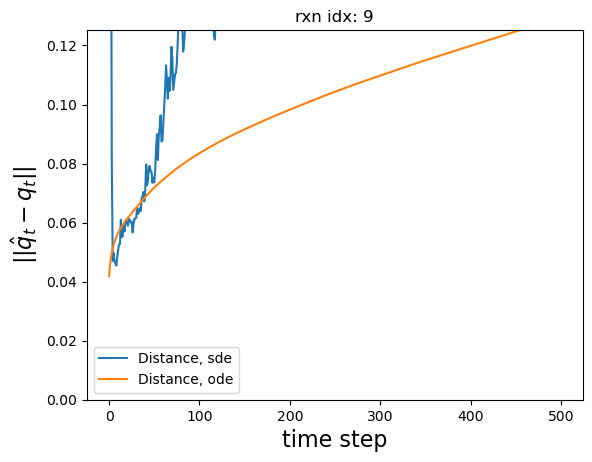

err_at_zero_t =  [3.0298359394073486, 0.04188795015215874]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


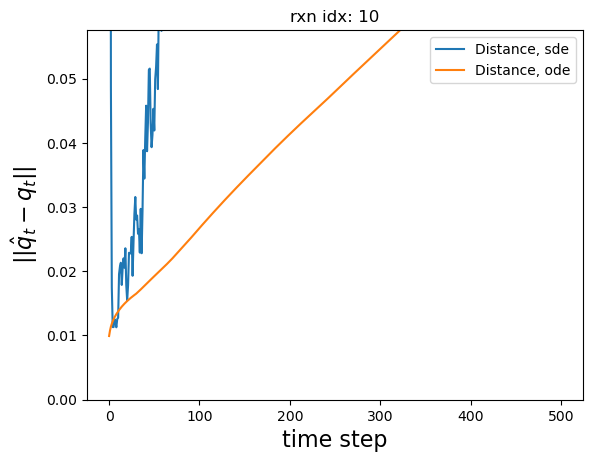

err_at_zero_t =  [6.690655708312988, 0.009919381700456142]
Done!


In [77]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
num_time_steps = 500
# num_time_steps = 50
# num_time_steps = 1000
# num_time_steps = 200
# num_time_steps = 100
# num_time_steps = 300

h_coeff = 0.0
verbose = True
verbose = False
# q_type = "DM"
q_type = "morse"
# q_type = "morse+DM"
print(f"q_type = {q_type}")

# for idx in [3, 7]:
for idx in [3,4,5,6,7,8,9,10]:
# for idx in [60, 320]:
# for idx in [42,60,78,238,304,344,458,718,746,774,884,913]:
# for idx in [42,60,78,238,304]:
# for idx in np.random.randint(0, 999, size=10):
    # idx = idx + 50
    err_at_zero_t = []
    v = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    # v = experiment1(idx, "sde", "Cartesian", h_coeff, num_time_steps, verbose=verbose, q_type="DM")
    # v = experiment1(idx, "sde", "Cartesian", h_coeff, num_time_steps, verbose=verbose, q_type=q_type)
    # err_at_zero_t.append(v[0].item())
    # v = experiment1(idx, "ode", "Cartesian", h_coeff, num_time_steps, verbose=verbose, q_type="DM")
    # v = experiment1(idx, "ode", "Cartesian", h_coeff, num_time_steps, verbose=verbose, q_type=q_type)
    # err_at_zero_t.append(v[0].item())
    # plt.ylim(0.0, 2.0)
    plt.ylim(0.0, v[num_time_steps//2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!")

## my sampling test

In [297]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3/wb97xd3_rxn_r.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_r.xyz"))
# atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3_geodesic/wb97xd3_geodesic_rxn_ts.xyz"))

# def experiment_my_sampling(idx, sampling_type, coord_type, h_coeff, num_time_steps=200, verbose=False, plot=True, q_type="morse"):
def experiment_my_sampling(idx, sampling_type, coord_type, h_coeff, num_time_steps=200, verbose=False, plot=True, q_type="morse", coeff=None):
    set_seed(0)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]

    alpha, beta = 1.7, 0.01
    # alpha, beta = 0.0, 1.0
    # alpha, beta = 0.5, 0.01
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta)
    # wrapper.scaler_factor = 10.0; print(f"Debug: self.scaler_factor set to {wrapper.scaler_factor}")
    
    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())
    # posT = pos0 + torch.randn_like(pos0) * 0.05

    t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s = []
    v2s = []

    for idx, i in enumerate(torch.flip(t, dims=(0,))):
        # coeff = 500.0
        x, v1, v2 = wrapper.my_sampling_process(x, i, dt, coeff[idx], pos0, posT, coord=coord_type)
        reverse_traj.append(x)
        v1s.append(v1)
        v2s.append(v2)

    if plot:
        label = f"{coord_type}, {sampling_type}"
        # plt.plot(v2s[::-1])
        # plt.plot(v4s[::-1])
        plt.plot(v1s[::-1], label=label+" DMAE")
        plt.plot(v2s[::-1], label=label+" Morse-RMSD")
        # plt.plot(v)
        # plt.plot(v3s[::-1])
        plt.xlabel(r"time step", fontsize=16)
        if q_type == "morse":
            plt.ylabel(r"||$\hat{q}_t - q_t$||", fontsize=16)
        elif q_type == "DM":
            plt.ylabel(r"||$\hat{d}_t - d_t$||", fontsize=16)
        else:
            raise NotImplementedError
    return v1s, v2s
    # return v1s[::-1]


def save_trajectory(filename, atoms):    
    for trj in mu_hat_list[::-1]:
        xT.set_positions(trj)
        ase.io.write(filename, xT, append=True)

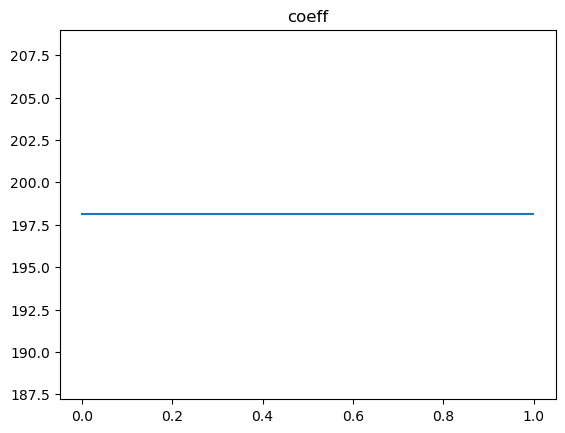

tensor(198.104462)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.11977734470187075
Debug: t=0.009000000543892384, diff_pos.norm()=0.00505990318504234
Debug: t=0.009000000543892384, score.norm()=1.002389396574736
Debug: t=0.009000000543892384, dx.norm()=0.0010023894441856774
Debug: t=0.00800000037997961, diff_d.norm()=0.11969271135840008
Debug: t=0.00800000037997961, diff_pos.norm()=0.005049520323137137
Debug: t=0.00800000037997961, score.norm()=1.0003325053064123
Debug: t=0.00800000037997961, dx.norm()=0.0010003325528196566
Debug: t=0.007000000216066837, diff_d.norm()=0.11960836537489414
Debug: t=0.007000000216066837, diff_pos.norm()=0.005039170929138788
Debug: t=0.007000000216066837, score.norm()=0.9982822441797596
Debug: t=0.007000000216066837, dx.norm()=0.000998282291595622
Debug: t=0.006000000052154064, diff_d.norm()=0.11952430552678212
Debug: t=0.006000000052154064, diff_pos.norm()=0.005028855206342858
Debug: t=0.006000000052154064, score.norm

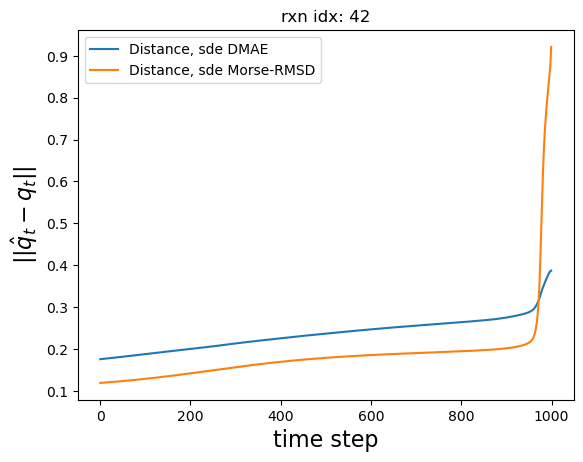

tensor(0.175582) tensor(0.118944, dtype=torch.float64)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.18016182051054125
Debug: t=0.009000000543892384, diff_pos.norm()=0.007320515023961159
Debug: t=0.009000000543892384, score.norm()=1.450226687968401
Debug: t=0.009000000543892384, dx.norm()=0.0014502267568504725
Debug: t=0.00800000037997961, diff_d.norm()=0.18004391719081236
Debug: t=0.00800000037997961, diff_pos.norm()=0.007321822972381412
Debug: t=0.00800000037997961, score.norm()=1.450485798386087
Debug: t=0.00800000037997961, dx.norm()=0.0014504858672804656
Debug: t=0.007000000216066837, diff_d.norm()=0.17992589478489426
Debug: t=0.007000000216066837, diff_pos.norm()=0.007323087770410109
Debug: t=0.007000000216066837, score.norm()=1.4507363605186832
Debug: t=0.007000000216066837, dx.norm()=0.0014507364294249628
Debug: t=0.006000000052154064, diff_d.norm()=0.17980775439777022
Debug: t=0.006000000052154064, diff_pos.norm()=0.007324313920805303
Debu

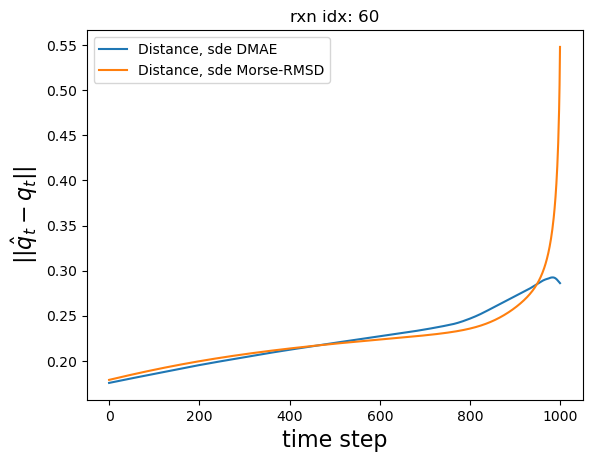

tensor(0.175612) tensor(0.178978, dtype=torch.float64)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.18071360925038019
Debug: t=0.009000000543892384, diff_pos.norm()=0.0007464106973100785
Debug: t=0.009000000543892384, score.norm()=0.14786728937528412
Debug: t=0.009000000543892384, dx.norm()=0.00014786729639860348
Debug: t=0.00800000037997961, diff_d.norm()=0.180712388216293
Debug: t=0.00800000037997961, diff_pos.norm()=0.0007458512263820289
Debug: t=0.00800000037997961, score.norm()=0.14775645568826284
Debug: t=0.00800000037997961, dx.norm()=0.00014775646270631792
Debug: t=0.007000000216066837, diff_d.norm()=0.18071116900327572
Debug: t=0.007000000216066837, diff_pos.norm()=0.0007452927285150763
Debug: t=0.007000000216066837, score.norm()=0.14764581476898642
Debug: t=0.007000000216066837, dx.norm()=0.00014764582178178632
Debug: t=0.006000000052154064, diff_d.norm()=0.1807099516070711
Debug: t=0.006000000052154064, diff_pos.norm()=0.000744735079320

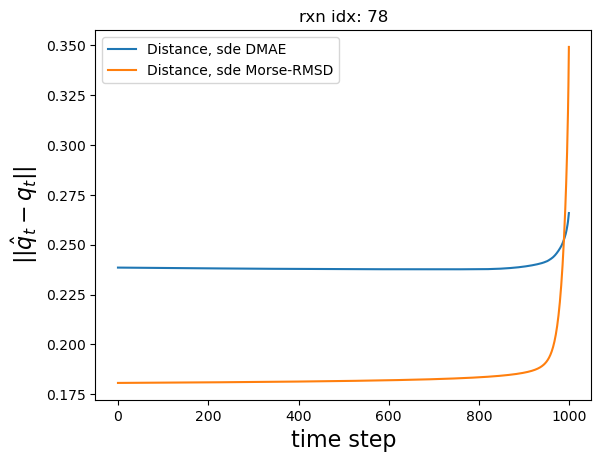

tensor(0.238520) tensor(0.180701, dtype=torch.float64)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.037381037073201784
Debug: t=0.009000000543892384, diff_pos.norm()=0.000372320586937567
Debug: t=0.009000000543892384, score.norm()=0.07375836944389605
Debug: t=0.009000000543892384, dx.norm()=7.37583729472306e-05
Debug: t=0.00800000037997961, diff_d.norm()=0.0373795697615595
Debug: t=0.00800000037997961, diff_pos.norm()=0.00037130387747364156
Debug: t=0.00800000037997961, score.norm()=0.07355695476287039
Debug: t=0.00800000037997961, dx.norm()=7.355695825663826e-05
Debug: t=0.007000000216066837, diff_d.norm()=0.037378110397037506
Debug: t=0.007000000216066837, diff_pos.norm()=0.00037028936191447006
Debug: t=0.007000000216066837, score.norm()=0.07335597470416495
Debug: t=0.007000000216066837, dx.norm()=7.33559781883868e-05
Debug: t=0.006000000052154064, diff_d.norm()=0.03737665893662832
Debug: t=0.006000000052154064, diff_pos.norm()=0.000369278963979

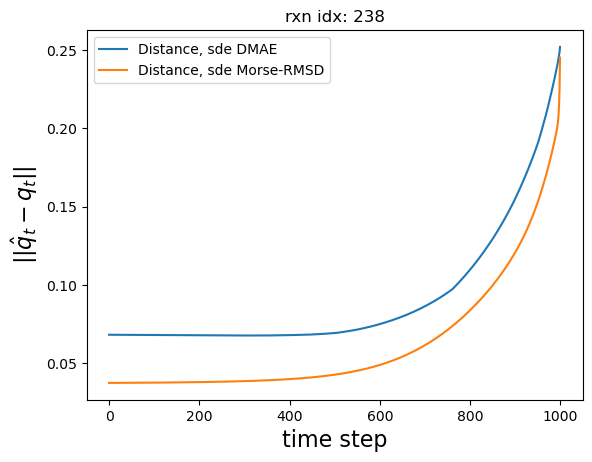

tensor(0.068147) tensor(0.037367, dtype=torch.float64)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.04663432467749779
Debug: t=0.009000000543892384, diff_pos.norm()=0.0017488892438583818
Debug: t=0.009000000543892384, score.norm()=0.3464627621748814
Debug: t=0.009000000543892384, dx.norm()=0.00034646277863097964
Debug: t=0.00800000037997961, diff_d.norm()=0.046608344779477645
Debug: t=0.00800000037997961, diff_pos.norm()=0.0017470633670057887
Debug: t=0.00800000037997961, score.norm()=0.3461010478239229
Debug: t=0.00800000037997961, dx.norm()=0.00034610106426284057
Debug: t=0.007000000216066837, diff_d.norm()=0.04658240464124284
Debug: t=0.007000000216066837, diff_pos.norm()=0.0017452413967337724
Debug: t=0.007000000216066837, score.norm()=0.34574010738400657
Debug: t=0.007000000216066837, dx.norm()=0.00034574012380578044
Debug: t=0.006000000052154064, diff_d.norm()=0.04655650416023607
Debug: t=0.006000000052154064, diff_pos.norm()=0.0017434229534

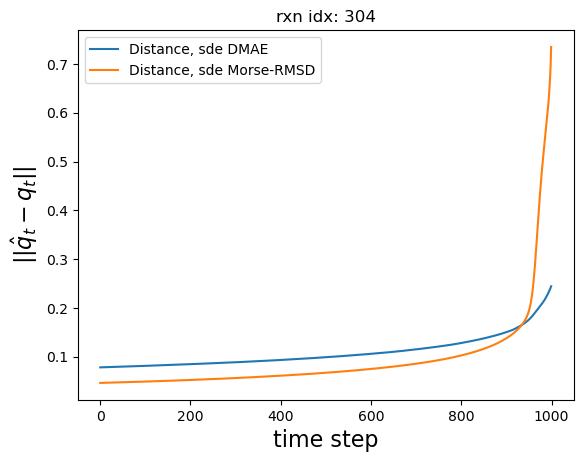

tensor(0.078254) tensor(0.046376, dtype=torch.float64)


In [440]:
# num_time_steps = 500
num_time_steps = 1000
h_coeff = 0.0
verbose = True
verbose = False
q_type = "DM"
q_type = "morse"

t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
# coeff = torch.ones(num_time_steps) *  500.0
coeff = torch.exp(- 5.0 * t**2) * 500
coeff = torch.ones(len(coeff)) * coeff.mean()
plt.title("coeff")
plt.plot(list(t)[::-1], coeff)
# plt.plot(list(t)[::-1], coeff * 1 / num_time_steps)
plt.show()
print(coeff[-1])

for idx in [42,60,78,238,304]:
# for idx in range(10):
# for idx in np.random.randint(0, 1000, size=5):
    err_at_zero_t = []
    v = experiment_my_sampling(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, coeff=coeff)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print(v[0][-1], v[1][-1])  # DMAE, q norm

# Hybrid sampling (d-space sampling + q-space sampling)



In [453]:
class HybridSampler:
    def __init__(self, atoms_0, atoms_T):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        self.d_sampler = Wrapper(atoms_0, atoms_T, q_type="DM")
        self.q_sampler = Wrapper(atoms_0, atoms_T, q_type="morse")
        # self.q_sampler.scaler_factor = 2.0; print(f"Debug: self.scaler_factor set to {self.q_sampler.scaler_factor}")
        
        self.i_t = 0
        return

    def hybrid_sampling_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=False, sampling_type="sde"):
        if sampling_type == "sde":
            if self.i_t % 2 == 0:
                x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            else:
                x_tm1, v1, v2, v3, v4 = self.q_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        elif sampling_type == "ode":
            if self.i_t % 2 == 0:
                x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            else:
                x_tm1, v1, v2, v3, v4 = self.q_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        self.i_t += 1
        return x_tm1, v1, v2, v3, v4

    def hybrid_sampling_process2(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=False, sampling_type="sde"):
        w_q = 0.5
        if sampling_type == "sde":
            x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            x_tm2, v1, v2, v3, v4 = self.q_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            # x_tm1 = (x_tm1 + x_tm2) / 2
            x_tm1 = (1 - w_q) * x_tm1 + w_q * x_tm2
        elif sampling_type == "ode":
            x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            x_tm2, v1, v2, v3, v4 = self.q_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            # x_tm1 = (x_tm1 + x_tm2) / 2
            x_tm1 = (1 - w_q) * x_tm1 + w_q * x_tm2
        return x_tm1, v1, v2, v3, v4

    def d_sampling_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=False, sampling_type="sde"):
        if sampling_type == "sde":
            x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        elif sampling_type == "ode":
            x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        return x_tm1, v1, v2, v3, v4

    def q_sampling_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=False, sampling_type="sde"):
        if sampling_type == "sde":
            x_tm1, v1, v2, v3, v4 = self.q_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        elif sampling_type == "ode":
            x_tm1, v1, v2, v3, v4 = self.q_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        return x_tm1, v1, v2, v3, v4

In [464]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3/wb97xd3_rxn_r.xyz"))
# atoms_T = list(ase.io.iread("pm7/pm7_rxn_r.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3_geodesic/wb97xd3_geodesic_rxn_ts.xyz"))


def experiment_hybrid_sampling(idx, sampling_type, coord_type, h_coeff, num_time_steps=200, verbose=False, plot=True):
    set_seed(0)
    # set_seed(2)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]

    hybrid_sampler = HybridSampler(x0, xT)
    
    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())
    # posT = pos0 + torch.randn_like(pos0) * 0.05

    t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s, v2s, v3s, v4s = [], [], [], []

    for idx, i in enumerate(torch.flip(t, dims=(0,))):
        # x, v1, v2, v3, v4 = hybrid_sampler.hybrid_sampling_process(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
        # x, v1, v2, v3, v4 = hybrid_sampler.hybrid_sampling_process2(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
        x, v1, v2, v3, v4 = hybrid_sampler.d_sampling_process(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
        reverse_traj.append(x)
        v1s.append(v1);        v2s.append(v2);        v3s.append(v3);        v4s.append(v4)

    for j in range(0):
        for idx, i in enumerate(torch.flip(t, dims=(0,))):
            if idx < num_time_steps - 100:
                continue
            # x, v1, v2, v3, v4 = hybrid_sampler.hybrid_sampling_process(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
            # x, v1, v2, v3, v4 = hybrid_sampler.hybrid_sampling_process2(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
            x, v1, v2, v3, v4 = hybrid_sampler.d_sampling_process(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
            reverse_traj.append(x)
            v1s.append(v1);        v2s.append(v2);        v3s.append(v3);        v4s.append(v4)
        

    if plot:
        label = f"{coord_type}, {sampling_type}"
        ## plt.plot(v2s[::-1], label=label)
        plt.plot(v4s[::-1], label=label)
        plt.xlabel(r"time step", fontsize=16)
        if q_type == "morse":
            plt.ylabel(r"||$\hat{q}_t - q_t$||", fontsize=16)
        # elif q_type == "DM":
        elif q_type in ["morse", "morse+DM"]:
            plt.ylabel(r"||$\hat{d}_t - d_t$||", fontsize=16)
        else:
            raise NotImplementedError
    return v4s[::-1]  # q norm
    # return v2s[::-1]  # DMAE


def save_trajectory(filename, atoms):    
    for trj in mu_hat_list[::-1]:
        xT.set_positions(trj)
        ase.io.write(filename, xT, append=True)

Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0


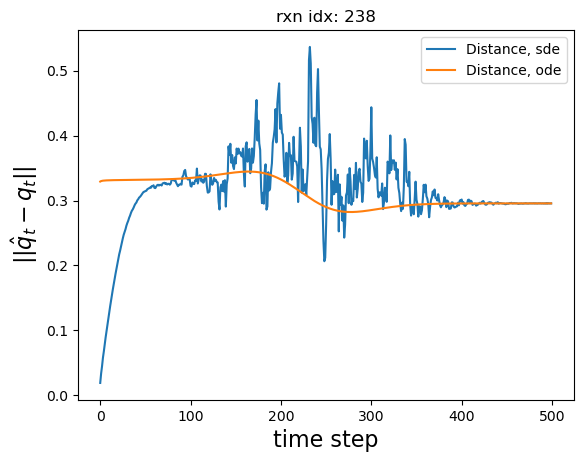

err_at_zero_t =  [0.019151706559246282, 0.3291578818389463]
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0


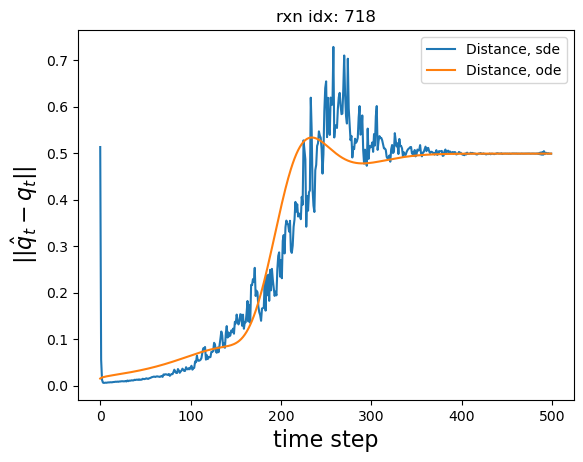

err_at_zero_t =  [0.5129816155515278, 0.015131125730026224]
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0


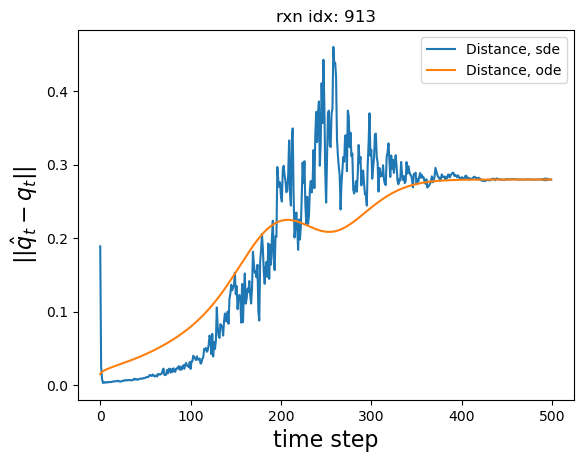

err_at_zero_t =  [0.18865771611172316, 0.01489076409658033]
Done!!!!!!!!


In [475]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
num_time_steps = 500
# num_time_steps = 50
# num_time_steps = 1000
# num_time_steps = 200
# num_time_steps = 100

h_coeff = 0.0
verbose = True
verbose = False


# for idx in [3, 7]:
# for idx in [3,4,5,6,7,8,9,10]:
# for idx in [60, 320]:
# for idx in [42,60,78,238,304,344,458,718,746,774,884,913]:
# for idx in [42,60,78,238,304]:
for idx in [238, 718, 913]:
    err_at_zero_t = []
    v = experiment_hybrid_sampling(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose)
    err_at_zero_t.append(v[0].item())
    v = experiment_hybrid_sampling(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose)
    err_at_zero_t.append(v[0].item())
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!!!!!!!!")

# =============================================================

In [130]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
# num_time_steps = 70
num_time_steps = 200
# num_time_steps = 1000
h_coeff = 0.0
plot = False
thr = 0.01
q_type = "morse"

print(f"* num_time_steps: {num_time_steps}")
print(f"* h_coeff: {h_coeff}")
print(f"* plot: {plot}")
print(f"* thr: {thr}")

import pickle
test_index_list = pickle.load(open("/home/share/DATA/NeuralOpt/data/data_split.pkl", "rb"))["test_index"]

## get index
idx_list = []
for _xT in atoms_T:
    file_info = list(_xT.info.keys())[0].split("/")[-1].split(".")[0]
    _idx = int(file_info[2:])
    idx_list.append(_idx)
idx_list = set(idx_list + list(test_index_list))
print(len(idx_list))
# print(idx_list)

for idx in idx_list:
    err_at_zero_t = []
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "sde", "Cartesian", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Cartesian", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())

    satisfy_thr = [_ < thr for _ in err_at_zero_t]
    if False in satisfy_thr:
        print(f"idx={idx}, err_at_zero_t={err_at_zero_t}")
print("Done!!!")

* num_time_steps: 200
* h_coeff: 0.0
* plot: False
* thr: 0.01
11961
Debug: self.scaler_factor set to 1.0
Debug: random noised pos0 is used as posT.


KeyboardInterrupt: 

In [43]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
# num_time_steps = 70
num_time_steps = 200
# num_time_steps = 1000
h_coeff = 0.0
plot = False
thr = 0.01
q_type = "morse"

print(f"* num_time_steps: {num_time_steps}")
print(f"* h_coeff: {h_coeff}")
print(f"* plot: {plot}")
print(f"* thr: {thr}")

import pickle
test_index_list = pickle.load(open("/home/share/DATA/NeuralOpt/data/data_split.pkl", "rb"))["test_index"]

## get index
idx_list = []
for _xT in atoms_T:
    file_info = list(_xT.info.keys())[0].split("/")[-1].split(".")[0]
    _idx = int(file_info[2:])
    idx_list.append(_idx)
idx_list = set(idx_list + list(test_index_list))
print(len(idx_list))
# print(idx_list)

for idx in idx_list:
    err_at_zero_t = []
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "sde", "Cartesian", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Cartesian", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())

    satisfy_thr = [_ < thr for _ in err_at_zero_t]
    if False in satisfy_thr:
        print(f"idx={idx}, err_at_zero_t={err_at_zero_t}")
print("Done!!!")

* num_time_steps: 200
* h_coeff: 0.0
* plot: False
* thr: 0.01
8275
idx=4, err_at_zero_t=[0.04948998987674713, 0.04948998987674713, 0.0008780219630610154, 2.1773866692356297e-05]
idx=6, err_at_zero_t=[0.0221781637519598, 0.0221781637519598, 0.0006407228636372799, 3.376008328597895e-05]
idx=8, err_at_zero_t=[0.027429277077317238, 0.027429277077317238, 0.0008462745849270783, 3.961639719412156e-05]
idx=9, err_at_zero_t=[0.031209025532007217, 0.031209025532007217, 0.0005900034164275976, 4.636562631753029e-05]


KeyboardInterrupt: 